In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Requirement 2: Adversarial Environment

In [17]:
# Pricing parameters
T = 200
K_prices = 30
cost = 0
prices = np.linspace(0,1,K_prices)
coef = np.random.uniform(0.5,1.5,T)
conversion_probability = np.zeros((T,K_prices))
for i in range(T):
    prob = np.ones(K_prices)-coef[i]*prices
    conversion_probability[i]=prob*(prob>0)
# reward_sequence = conversion_probability*(prices-cost)

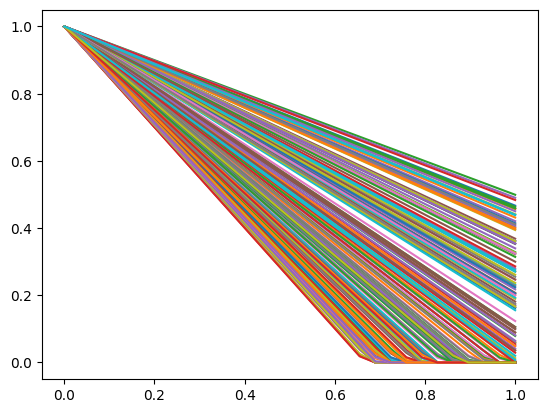

In [18]:
for i in range(T):
    plt.plot(prices,conversion_probability[i])

In [19]:
# Auctions parameters
n_users = 40        # number of users each day
K_bids = 11         # number of available bids
B = 20              # budget
rho = B/n_users     # budget per round

n_slots = 3         # number of slots
lmb = np.array([0.6, 0.7, 0.9])

n_advertisers = 6   # number of advertisers (including us)
q = np.array([0.9, 0.7, 0.5, 0.6, 0.85, 0.65]) # ad quality
v = np.array([1.0, 1.0, 1.0, 0.85, 1.0, 0.9])  # advertisers value per click

# competitors sample bids from a uniform with range varying over time
pattern = lambda t: 0.8-np.abs(np.sin(5*t/n_users)/2)
other_bids = np.array([np.random.uniform(0.2, pattern(t), size = n_advertisers-1) for t in range(n_users)]).T

adv_ranking = np.sort(other_bids, axis=0)
m_t = adv_ranking[-n_slots]

print(len(m_t),m_t)

available_bids = np.linspace(0,1,K_bids)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

40 [0.42908909 0.42539054 0.39305546 0.33540694 0.41684948 0.38559918
 0.37699654 0.30874911 0.29333474 0.29179961 0.30516721 0.25905241
 0.25657689 0.27267058 0.22328063 0.30133195 0.26129117 0.2715956
 0.33444461 0.25747707 0.42306081 0.33548568 0.49184787 0.39537185
 0.44149867 0.52272676 0.33469318 0.51284289 0.46519302 0.36198836
 0.29266659 0.29196213 0.25852483 0.24399084 0.3142745  0.26433824
 0.2683811  0.25442737 0.26057081 0.28796595]


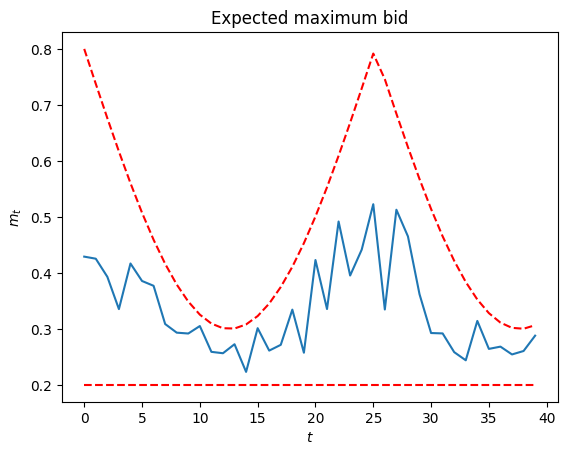

In [20]:
plt.plot(m_t)
plt.plot([pattern(t) for t in range(n_users)], 'r--')
plt.plot([0.2 for t in range(n_users)], 'r--')
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

## Environments

In [21]:
# Princing Environment
class AdversarialExpertEnvironment:
    def __init__(self, conversion_probability):
        self.conversion_probability = conversion_probability
        self.K = len(prices)
        self.t = 0

    def round(self): # we do not need to receive a specific arm
        prob_t = self.conversion_probability[self.t, :] # we return the whole loss vector
        self.t+=1
        return prob_t

In [22]:
# Auctions Environment
class FirstPriceAuction:
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots = n_slots

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-self.n_slots:]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)
    
    def round(self, bids):
        winners, values = self.get_winners(bids)
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

## Agents

In [23]:
# Pricing Agent
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, r_t):
        self.weights *= np.exp(-self.learning_rate*(1-r_t))
        self.t += 1

In [24]:
# Auctions Agent

# Regret minimizer for multiplicative pacing
class RegretMinimizer_Hedge:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

# Multiplicative pacing agent
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = RegretMinimizer_Hedge(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        # self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        chosen_bid = self.bids_set[self.hedge.pull_arm()]
        return chosen_bid

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

In [25]:
# ctrs = np.array([0.8, 0.65, 0.50, 0.75, 0.85, 0.60])
ctrs = np.ones(n_advertisers)
n_auctions= 10
auction = FirstPriceAuction(ctrs, n_slots)
for u in range(n_auctions):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_advertisers)
    pub_values = bids*ctrs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winners, payments_per_click = auction.round(bids=bids)
    print(f'Auction Winners: {winners}, Payment-per-click: {payments_per_click}')
    print(f'Payment <= Bid : {(payments_per_click <= bids[winners]).all()}')


# User 0
Bids: [0.5  0.75 0.75 0.5  0.75 0.5 ], Publisher Values: [0.5  0.75 0.75 0.5  0.75 0.5 ]
Auction Winners: [1 2 4], Payment-per-click: [0.75 0.75 0.75]
Payment <= Bid : True
# User 1
Bids: [1.   1.   0.75 0.5  1.   1.  ], Publisher Values: [1.   1.   0.75 0.5  1.   1.  ]
Auction Winners: [1 4 5], Payment-per-click: [1. 1. 1.]
Payment <= Bid : True
# User 2
Bids: [0.75 0.25 0.75 0.5  0.75 0.25], Publisher Values: [0.75 0.25 0.75 0.5  0.75 0.25]
Auction Winners: [0 2 4], Payment-per-click: [0.75 0.75 0.75]
Payment <= Bid : True
# User 3
Bids: [1.   0.5  0.25 0.25 0.75 1.  ], Publisher Values: [1.   0.5  0.25 0.25 0.75 1.  ]
Auction Winners: [4 0 5], Payment-per-click: [0.75 1.   1.  ]
Payment <= Bid : True
# User 4
Bids: [1.   0.25 0.75 1.   1.   1.  ], Publisher Values: [1.   0.25 0.75 1.   1.   1.  ]
Auction Winners: [3 4 5], Payment-per-click: [1. 1. 1.]
Payment <= Bid : True
# User 5
Bids: [0.75 1.   0.25 0.25 1.   0.5 ], Publisher Values: [0.75 1.   0.25 0.25 1.   0.5 ]
Auct

## Interaction

In [55]:
pricing_learning_rate = np.sqrt(np.log(K_prices)/T)
pricingEnv = AdversarialExpertEnvironment(conversion_probability)
pricingAgent = HedgeAgent(K_prices,pricing_learning_rate)

auctions_learning_rate = 1/np.sqrt(n_users)
auctionsEnv = FirstPriceAuction(q, n_slots)

agent_reward = np.array([])
expected_agent_reward = np.array([])

reward_sequence = np.zeros((T,K_prices))
counter = 0
my_payments = np.zeros((T,n_users))
my_prices = np.zeros(T)
for t in range(T):
    # PRICING ROUND
    a_t = pricingAgent.pull_arm()
    p_t=prices[a_t]
    my_prices[t] = p_t
    buy_probabilities = pricingEnv.round()
    todays_cost = np.zeros(K_prices)
    n_clicks = np.zeros(K_prices)
    for a in range(K_prices):
        auctionsAgent = FFMultiplicativePacingAgent(available_bids, prices[a], B, n_users, auctions_learning_rate)
        for u in range(n_users):
            # AUCTIONS ROUND
            my_bid = auctionsAgent.bid()
            if a == a_t and my_bid>p_t:
                counter+=1
            all_bids = np.append(my_bid, other_bids[:, u].ravel())
            winners, payments_per_click = auctionsEnv.round(all_bids)
            # update auctions agent
            if 0 in winners:
                my_win = 1
                my_slot = np.where(winners == 0)[0]
                c_t = payments_per_click[my_slot]
                f_t = p_t-c_t
                # f_t = v[0]-c_t
                ctr = lmb[my_slot]*q[0]
            else:
                my_win = 0
                c_t = 0
                f_t = 0
                ctr = 0
            auctionsAgent.update(f_t, c_t, m_t[u])
            if random.random() < ctr:
                n_clicks[a] += 1
                todays_cost[a] += c_t
                if a == a_t : my_payments[t,u] = c_t
        reward_sequence[t,a] = n_clicks[a]*prices[a]*buy_probabilities[a]#-todays_cost[a]
    # Hedge needs losses (in our case rewards) in [0,1]
    reward_sequence[t] = (reward_sequence[t]-np.min(reward_sequence[t]))/(np.max(reward_sequence[t])-np.min(reward_sequence))
    print(f'Round {t}: {n_clicks[a_t]} clicks, {round(float(todays_cost[a_t]),2)} cost, {round(float(reward_sequence[t,a_t]),2)} reward')
    pricingAgent.update(reward_sequence[a_t])
    # logging
    agent_reward = np.append(agent_reward, reward_sequence[t,a_t])
    expected_agent_reward = np.append(expected_agent_reward, (reward_sequence[t] @ pricingAgent.x_t))


Round 0: 16.0 clicks, 6.9 cost, 0.24 reward
Round 1: 15.0 clicks, 6.9 cost, 0.6 reward
Round 2: 18.0 clicks, 10.2 cost, 0.0 reward
Round 3: 13.0 clicks, 6.0 cost, 0.56 reward
Round 4: 18.0 clicks, 8.8 cost, 0.0 reward
Round 5: 22.0 clicks, 11.3 cost, 0.67 reward
Round 6: 13.0 clicks, 6.8 cost, 0.18 reward
Round 7: 15.0 clicks, 7.5 cost, 0.52 reward
Round 8: 16.0 clicks, 8.9 cost, 0.57 reward
Round 9: 17.0 clicks, 8.9 cost, 0.76 reward
Round 10: 18.0 clicks, 9.5 cost, 0.82 reward
Round 11: 24.0 clicks, 11.8 cost, 1.0 reward
Round 12: 12.0 clicks, 6.5 cost, 0.64 reward
Round 13: 9.0 clicks, 6.0 cost, 0.5 reward
Round 14: 20.0 clicks, 11.2 cost, 0.92 reward
Round 15: 24.0 clicks, 14.2 cost, 0.5 reward
Round 16: 11.0 clicks, 6.0 cost, 0.53 reward
Round 17: 22.0 clicks, 11.9 cost, 0.38 reward
Round 18: 17.0 clicks, 9.1 cost, 0.82 reward
Round 19: 16.0 clicks, 8.9 cost, 0.86 reward
Round 20: 18.0 clicks, 9.2 cost, 0.38 reward
Round 21: 16.0 clicks, 9.0 cost, 0.59 reward
Round 22: 16.0 clicks

The auctions agent bid higher than the product price 25.12 % of the time


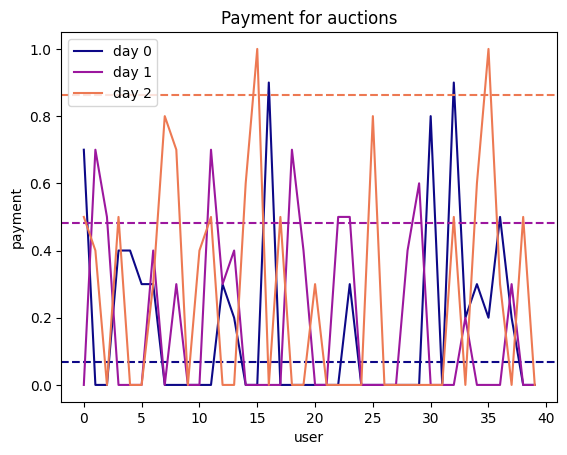

In [56]:
print(f"The auctions agent bid higher than the product price {round(100*counter/(T*n_users),2)} % of the time")

plt.title('Payment for auctions')
stop=3
for t in range(stop):
    plt.plot(my_payments[t,:], label=f'day {t}')
    plt.axhline(my_prices[t], linestyle='--')
plt.xlabel('user')
plt.ylabel('payment')

# After you plotted them, apply a random color to each curve.
import matplotlib
colormap = matplotlib.colormaps["plasma"] # The various colormaps can be found here: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax = plt.gca()
lines = ax.lines
N = len(lines)
for n in range(0, N, 2): # For each two-lines made via `plt.plot(...)`:
    random_color = colormap(n/N) # This function takes a number between 0 and 1 and returns a color.
    lines[n].set_color(random_color)
    lines[n+1].set_color(random_color)
plt.legend()
plt.show()

0.4482758620689655


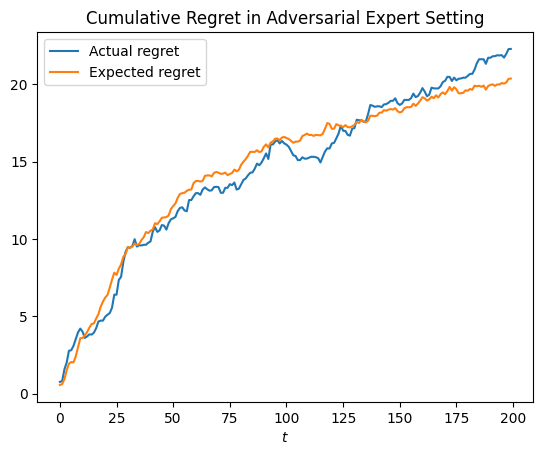

In [57]:
# Pricing performance
best_arm = np.argmax(reward_sequence.sum(axis=0))
print(prices[best_arm])
clairvoyant_reward = reward_sequence[:, best_arm]

plt.plot(np.cumsum(clairvoyant_reward-agent_reward), label='Actual regret')
plt.plot(np.cumsum(clairvoyant_reward-expected_agent_reward), label='Expected regret')
plt.title('Cumulative Regret in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

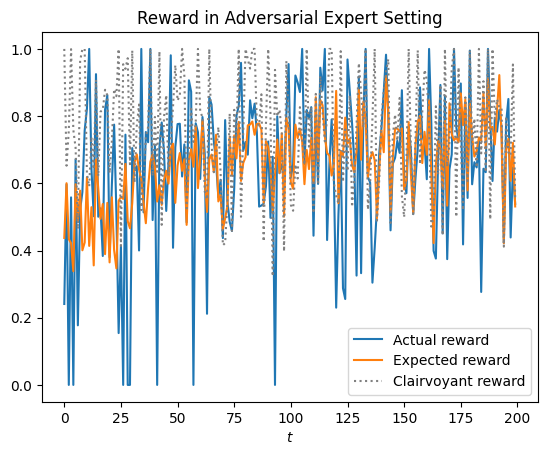

In [58]:
plt.plot(agent_reward, label='Actual reward')
plt.plot(expected_agent_reward, label='Expected reward')
plt.plot(clairvoyant_reward, label='Clairvoyant reward', linestyle=':', color='grey')
plt.title('Reward in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()

reward_sequence : min=0.0, max=1.0


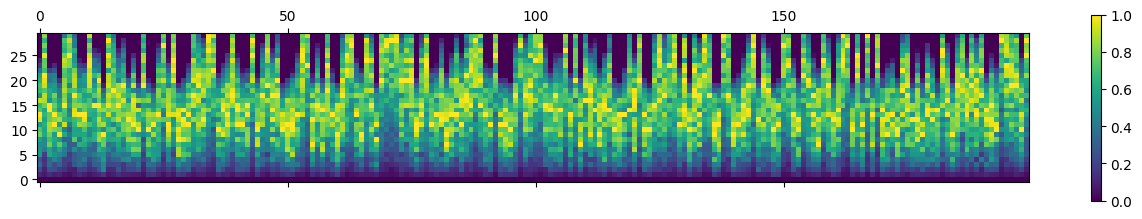

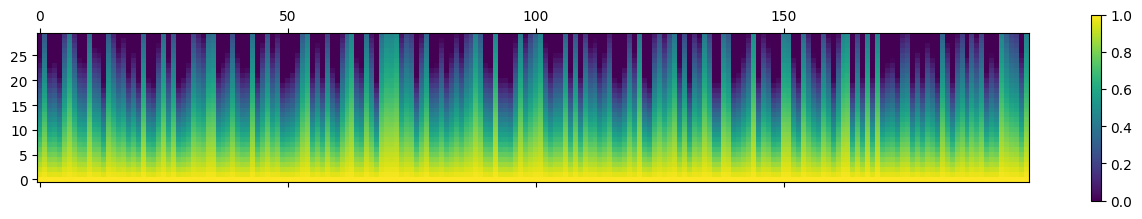

In [59]:
print(f"reward_sequence : min={reward_sequence.min()}, max={reward_sequence.max()}")
plt.matshow(reward_sequence.T, origin='lower')
plt.colorbar()
plt.matshow(conversion_probability.T, origin='lower')
plt.colorbar()